In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return torch.LongTensor(input_batch), torch.LongTensor(output_batch), torch.LongTensor(target_batch)

In [3]:
def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return torch.FloatTensor(sinusoid_table)

In [4]:
def get_attn_pad_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)
    return pad_attn_mask.expand(batch_size, len_q, len_k)

In [5]:
def get_attn_subsequent_mask(seq):
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask

In [6]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k)
        scores.masked_fill_(attn_mask, -1e9)
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
        self.linear = nn.Linear(n_heads * d_v, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, Q, K, V, attn_mask):
        residual, batch_size = Q, Q.size(0)

        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)


        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v)
        output = self.linear(context)
        return self.layer_norm(output + residual), attn

In [9]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return self.layer_norm(output + residual)

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)
        enc_outputs = self.pos_ffn(enc_outputs)
        return enc_outputs, attn

In [12]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs):
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

In [14]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

In [15]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs)
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

In [16]:
def showgraph(attn):
    attn = attn[-1].squeeze(0)[0]
    attn = attn.squeeze(0).data.numpy()
    fig = plt.figure(figsize=(n_heads, n_heads))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

Epoch: 0001 cost = 2.375995
Epoch: 0002 cost = 2.580482
Epoch: 0003 cost = 2.836507
Epoch: 0004 cost = 2.006746
Epoch: 0005 cost = 6.481443
Epoch: 0006 cost = 2.493108
Epoch: 0007 cost = 3.161588
Epoch: 0008 cost = 4.688381
Epoch: 0009 cost = 3.933287
Epoch: 0010 cost = 3.091499
Epoch: 0011 cost = 2.562795
Epoch: 0012 cost = 1.970432
Epoch: 0013 cost = 2.075418
Epoch: 0014 cost = 2.088581
Epoch: 0015 cost = 1.852522
Epoch: 0016 cost = 1.688514
Epoch: 0017 cost = 1.682590
Epoch: 0018 cost = 1.722264
Epoch: 0019 cost = 1.750186
Epoch: 0020 cost = 1.767346
Epoch: 0021 cost = 1.778736
Epoch: 0022 cost = 1.780137
Epoch: 0023 cost = 1.766292
Epoch: 0024 cost = 1.737096
Epoch: 0025 cost = 1.697601
Epoch: 0026 cost = 1.656719
Epoch: 0027 cost = 1.625419
Epoch: 0028 cost = 1.612864
Epoch: 0029 cost = 1.620716
Epoch: 0030 cost = 1.640733
Epoch: 0031 cost = 1.659458
Epoch: 0032 cost = 1.666684
Epoch: 0033 cost = 1.660533
Epoch: 0034 cost = 1.646295
Epoch: 0035 cost = 1.631506
Epoch: 0036 cost = 1

C:\Users\kiwi1\AppData\Local\Temp\ipykernel_23320\265351919.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
C:\Users\kiwi1\AppData\Local\Temp\ipykernel_23320\265351919.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})


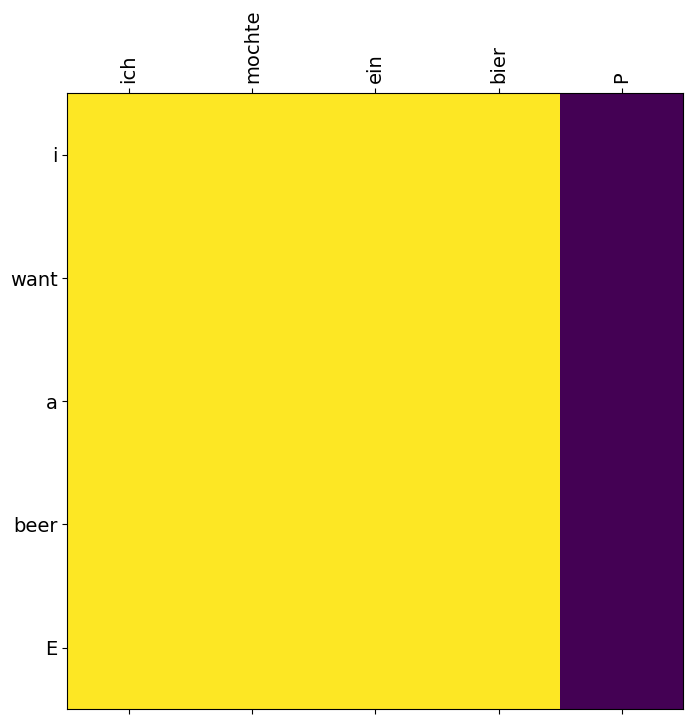

first head of last state dec_self_attns


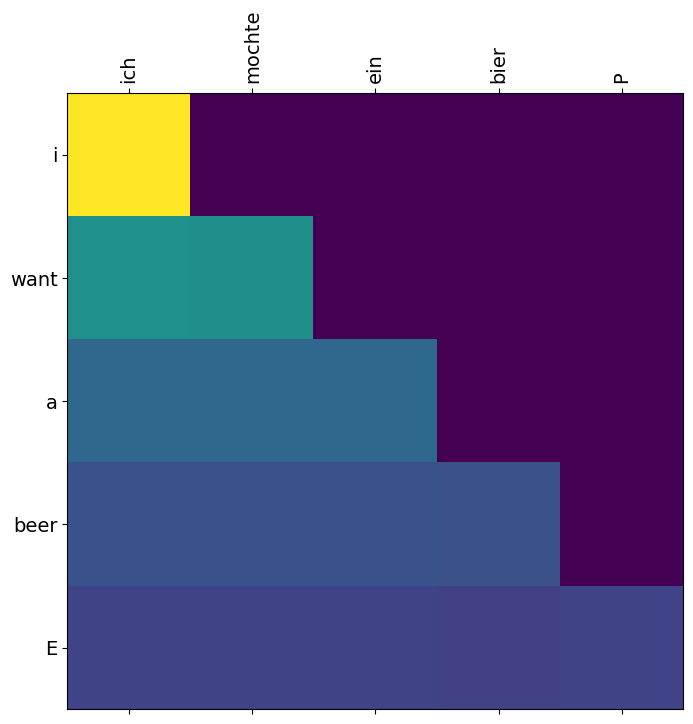

first head of last state dec_enc_attns


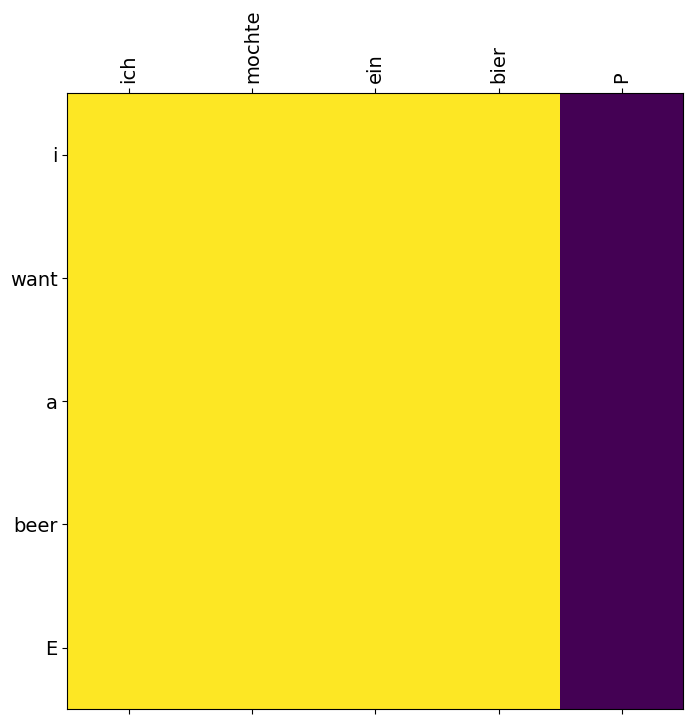

In [23]:
if __name__ == '__main__':
    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

    src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'bier': 4}
    src_vocab_size = len(src_vocab)

    tgt_vocab = {'P': 0, 'i': 1, 'want': 2, 'a': 3, 'beer': 4, 'S': 5, 'E': 6}
    number_dict = {i: w for i, w in enumerate(tgt_vocab)}
    tgt_vocab_size = len(tgt_vocab)

    src_len = 5
    tgt_len = 5

    d_model = 512
    d_ff = 2048
    d_k = d_v = 64
    n_layers = 6
    n_heads = 8

    model = Transformer()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    enc_inputs, dec_inputs, target_batch = make_batch(sentences)

    for epoch in range(40):
        optimizer.zero_grad()
        outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
        loss = criterion(outputs, target_batch.contiguous().view(-1))
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
        loss.backward()
        optimizer.step()

    # Test
    predict, _, _, _ = model(enc_inputs, dec_inputs)
    predict = predict.data.max(1, keepdim=True)[1]
    print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

    print('first head of last state enc_self_attns')
    showgraph(enc_self_attns)

    print('first head of last state dec_self_attns')
    showgraph(dec_self_attns)

    print('first head of last state dec_enc_attns')
    showgraph(dec_enc_attns)